# IMU Fitness Basic Dataset - Demo Notebook

This notebook shows how to:
1. Load and visualize the IMU data and rep count labels for a specific dataset sample
2. Convert the IMU data between various 3D rotation representations
3. Query the dataset based on specific metadata

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import numpy.typing as npt
import matplotlib.pyplot as plt
from IPython.display import Video
from scipy.spatial.transform import Rotation

plt.style.use("seaborn-deep")

**Helper Methods**

In [2]:
rotation_matrix_labels = [
        "rotation_matrix_m11",
        "rotation_matrix_m12",
        "rotation_matrix_m13",
        "rotation_matrix_m21",
        "rotation_matrix_m22",
        "rotation_matrix_m23",
        "rotation_matrix_m31",
        "rotation_matrix_m32",
        "rotation_matrix_m33",
    ]

def load_rotation_matrices(data_path: str) -> npt.NDArray[np.float64]:
    """Loads rotation matrices from a dataset csv file."""
    sensor_data = pd.read_csv(data_path)
    return sensor_data[rotation_matrix_labels].values.reshape(-1, 3, 3)

def load_rep_labels(data_path: str) -> npt.NDArray[np.float64]:
    """Loads rep labels from a dataset csv file."""
    sensor_data = pd.read_csv(data_path)
    return sensor_data["rep_count_from_start"].values

def plot_rotation_matrices_with_rep_labels(
    rotation_matrices: npt.NDArray[np.float64], 
    rep_label: npt.NDArray[np.float64]
):
    """Visualizes rotation matrices with rep labels for a dataset sample.
    
    Args:
        rotation_matrices: A numpy array containing the rotation matrices (3D orientation) from the IMU sensor.
        rep_label: A numpy array containing the frame-by-frame rep label.
    """
    fig, ax = plt.subplots(2, 1, figsize=(10, 4), dpi=200)
    ax[0].plot(rep_label % 1);
    ax[0].set_title("Rep Label")
    ax[1].plot(rotation_matrices.reshape(-1, 9), label=[rm.split("_")[-1] for rm in rotation_matrix_labels])
    ax[1].set_title("Rotation Matrices")
    plt.legend(loc = "center right")
    plt.tight_layout()
    plt.show()

## Demo 1: Loading and visualizing a single dataset sample

We have added a single example from the dataset to this repo (`./sample_data`). Here, we demonstrate how to load and visualize the rotation matrices and frame-synced rep labels. 

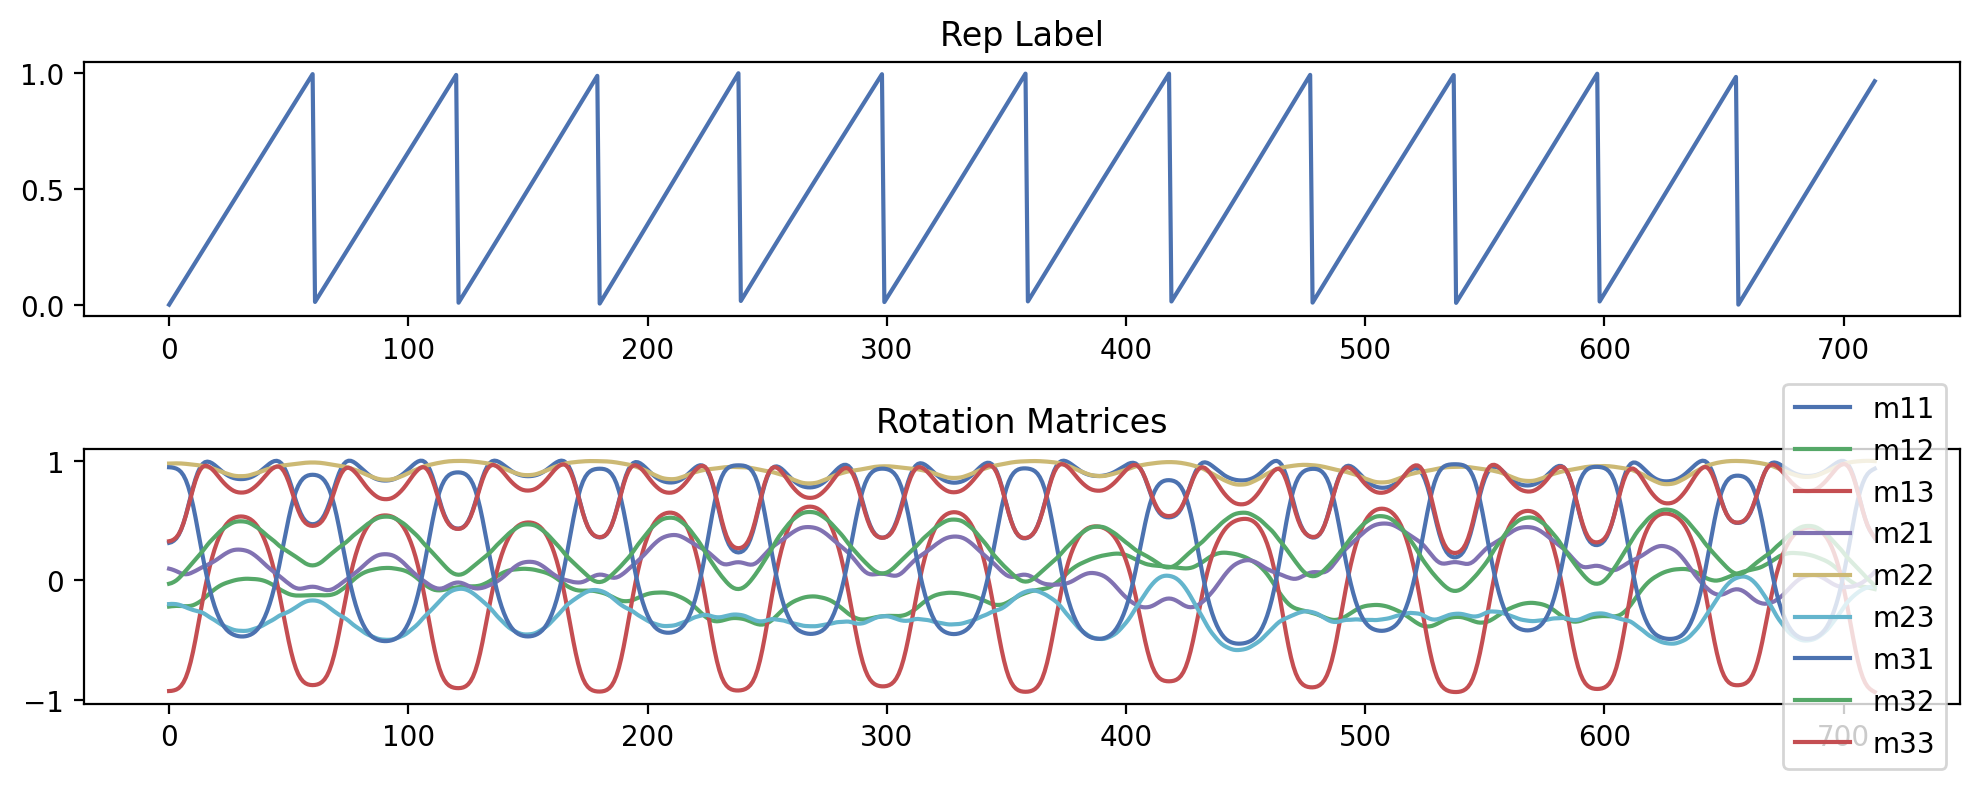

In [3]:
# load the rotation matrices and rep label.
rotation_matrices = load_rotation_matrices("sample_data/00000.csv")
rep_labels = load_rep_labels("sample_data/00000.csv")

# plot the rotation matrices and rep label.
plot_rotation_matrices_with_rep_labels(rotation_matrices, rep_labels)

## Demo 2: Conversion to Quaternions & Eulers

The IMU Fitness Basic Dataset represents angular position using rotation matrices. Here, we show how rotation matrices can be easily converted to quaternions or eulers using `scipy`.

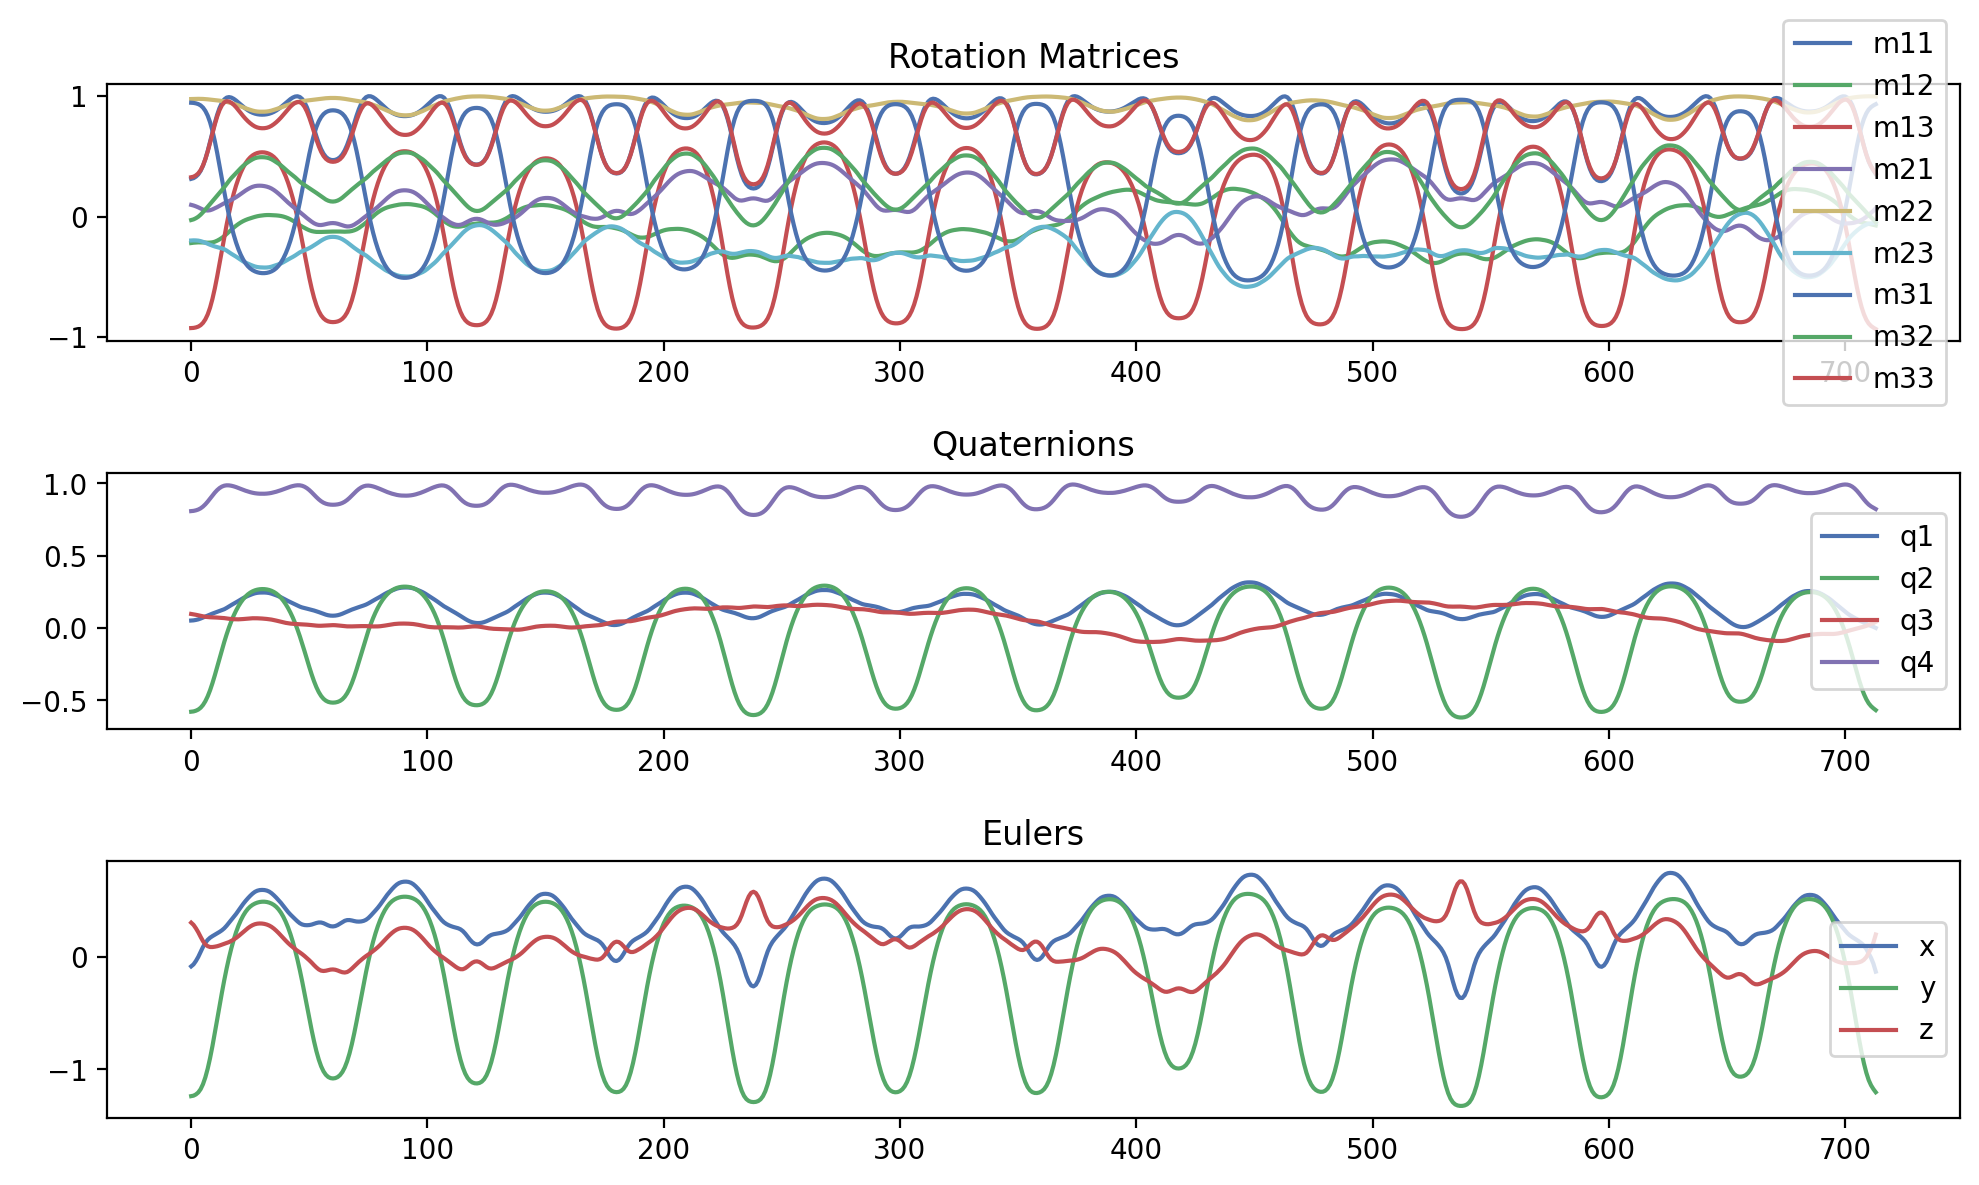

In [4]:
# convert rotation matrices to quaternions.
quaternions = Rotation.from_matrix(rotation_matrices).as_quat()

# convert rotation matrices to eulers.
eulers = Rotation.from_matrix(rotation_matrices).as_euler("xyz")

# plot rotation matrix, quaternion, and euler representations.
fig, ax = plt.subplots(3, 1, figsize=(10, 6), dpi=200)

ax[0].set_title("Rotation Matrices")
ax[0].plot(rotation_matrices.reshape(-1, 9), label=[rm.split("_")[-1] for rm in rotation_matrix_labels]);
ax[0].legend(loc="center right")

ax[1].set_title("Quaternions")
ax[1].plot(quaternions, label=["q1", "q2", "q3", "q4"]);
ax[1].legend()
ax[1].legend(loc="center right")

ax[2].set_title("Eulers")
ax[2].plot(eulers, label=["x", "y", "z"]);
ax[2].legend()
ax[2].legend(loc="center right")

plt.tight_layout()
plt.show()

## Demo 3: Querying samples from the dataset based on provided metadata

The IMU Fitness Basic Dataset contains 2000 samples with a wide variety of parameters. Here, we show how this metadata can be organized into an easily queryable dataframe using `pandas`. 

In [5]:
PATH_TO_EXERCISE_FOLDER = "PATH_TO_SINGLE_EXERCISE_FOLDER"

In [6]:
all_param_paths = sorted(glob.glob(os.path.join(PATH_TO_EXERCISE_FOLDER, "*_params.json")))

metadata = []
for param_path in all_param_paths:
    metadata_dict = {}
    metadata_dict["video_number"] = os.path.basename(param_path).split("_")[0]
    parameters = json.load(open(param_path))["params"]
    metadata_dict.update(parameters)
    metadata_dict["imu_path"] = param_path.replace("_params.json", ".csv")
    metadata_dict["video_path"] = param_path.replace("_params.json", ".mp4")
    metadata_dict["parameter_path"] = param_path
    metadata.append(metadata_dict)

metadata = pd.DataFrame(metadata)
metadata.head()

,video_number,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,...,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,imu_path,video_path,parameter_path
0,00000,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,...,True,20,480,480,677412957,1.0,100,/tmp/data/00000.csv,/tmp/data/00000.mp4,/tmp/data/00000_params.json
1,00001,ARM_RAISE-DUMBBELL,8,LEFT,LEFT,1.974947,0.686366,0.415175,0.103478,0.046946,...,True,20,480,480,883440248,1.0,100,/tmp/data/00001.csv,/tmp/data/00001.mp4,/tmp/data/00001_params.json
2,00002,ARM_RAISE-DUMBBELL,14,RIGHT,RIGHT,3.497341,0.787689,0.386297,0.025928,0.382219,...,True,20,480,480,165691495,1.0,100,/tmp/data/00002.csv,/tmp/data/00002.mp4,/tmp/data/00002_params.json
3,00003,ARM_RAISE-DUMBBELL,9,LEFT,LEFT,2.295498,1.038497,0.198922,0.008093,0.311103,...,True,20,480,480,575865703,1.0,100,/tmp/data/00003.csv,/tmp/data/00003.mp4,/tmp/data/00003_params.json
4,00004,ARM_RAISE-DUMBBELL,10,RIGHT,RIGHT,5.846361,1.081453,0.090164,0.173678,0.264158,...,True,20,480,480,1794010715,1.0,100,/tmp/data/00004.csv,/tmp/data/00004.mp4,/tmp/data/00004_params.json


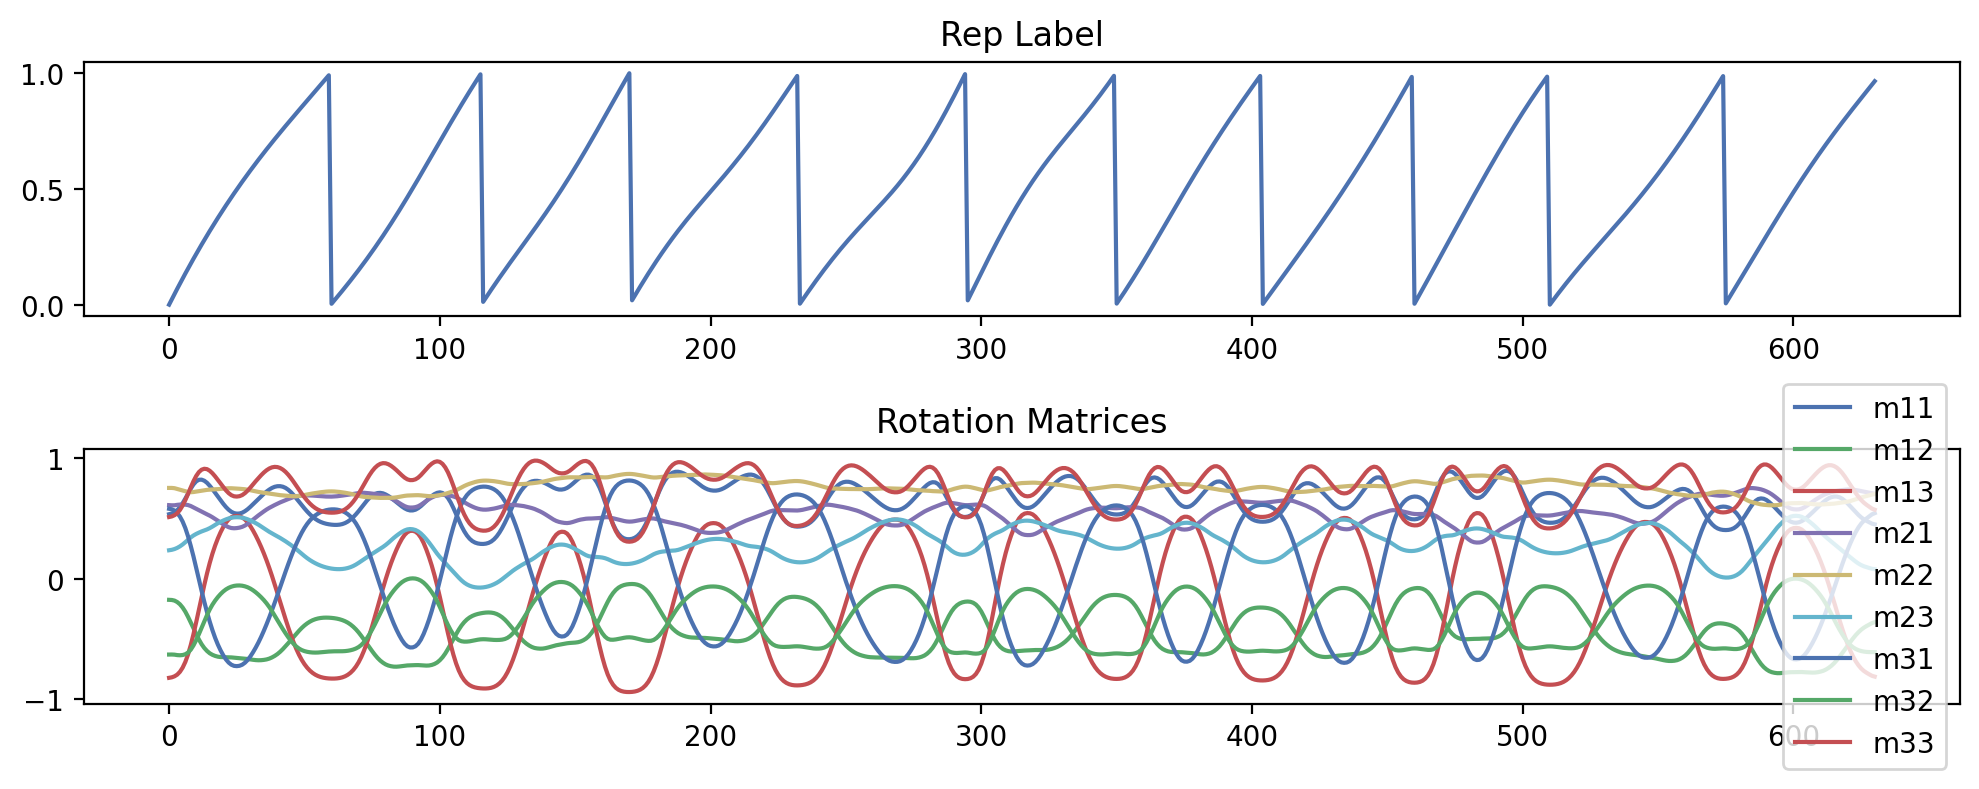

In [7]:
# select any row in metadata.
sample = metadata.query("max_rel_speed_change > 0.3").sample(1).squeeze()

# load the rotation matrices and rep label.
rotation_matrices = load_rotation_matrices(sample.imu_path)
rep_labels = load_rep_labels(os.path.join(sample.imu_path))

# plot the rotation matrices and rep label.
plot_rotation_matrices_with_rep_labels(rotation_matrices, rep_labels)